## NLP Classification WSB

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from fastai import *
from fastai.text import *

In [4]:
@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

### Check GPU and RAM

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Jan  5 10:04:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


### Load database

In [7]:
df_clean = pd.read_csv('/content/drive/My Drive/wsb/database_aug_clean.csv')
df_raw = pd.read_csv('/content/drive/My Drive/wsb/database_aug.csv')

In [8]:
len(df_raw)

3019

In [9]:
train, test = train_test_split(df_clean[df_clean.date>="2018-01-01"], test_size=0.15, random_state=42)

#### Params

In [10]:
root_dir = "/content/drive/My Drive/"
base_dir = root_dir + 'wsb/'

In [11]:
dest = Path(base_dir)
try:
  dest.mkdir(parents=True, exist_ok=False)
except FileExistsError:
  print ('File Already Exists')

File Already Exists


#### Language model 

In [ ]:
data_lm = (TextList.from_df(df_raw, cols='text')
                .split_by_rand_pct(0.1)
                .label_for_lm()  
                .databunch(bs=128, backwards=False, num_workers=1))
data_lm.show_batch()

In [ ]:
data_lm.save(dest/'databunch_fwd')

In [ ]:
learn = language_model_learner(data_lm, AWD_LSTM, pretrained=True, drop_mult=1.).to_fp16()

In [ ]:
# select the appropriate learning rate
learn.lr_find()

In [ ]:
# we typically find the point where the slope is steepest
learn.recorder.plot()

In [ ]:
lr = 1e-3
lr *= bs/48

In [ ]:
# fit the model based on selected learning rate
learn.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

In [ ]:
# tune it
learn.unfreeze()
learn.fit_one_cycle(6, lr, moms=(0.8,0.7))

In [ ]:
# save the encoder for use in classification
learn.save_encoder(dest/'fine_tuned_enc_fwd')
learn.save(dest/'fine_tuned_fwd')

In [ ]:
learn.predict("Chatter on the trading room floor is that TSLA will", n_words=10)

### Classifier model

In [12]:
data_lm = load_data(dest, 'databunch_fwd', bs=128, num_workers=1, backwards=False)

In [13]:
bs = 32

In [16]:
data_clas_fwd = (TextList.from_df(train, cols='text', vocab=data_lm.vocab)
             .split_by_rand_pct(0.1)
             .label_from_df(cols= 'label')
             .databunch(bs=bs, backwards=False, num_workers=1))

data_clas_fwd.show_batch()

text,target
"xxbos if he was a more efficient coder he would know that ff would work just the same . ah , maybe it was taken , by his xxunk . passive sjw at its finest . . i have 237.5 calls expiring 10 12 . i guess i 'm holding through earnings . i have puts which are slightly up due to afternoon correction . i will probably dump them",0
"xxbos hey , i 'm down $ 5,000 on amd shares alone . so at least you are not me . shit . su bae will punish you . also a small put position in survey monkey . fuck amd . not political , just a perfect storm of events . rising interest rates plus tariffs are making stocks not looking so great going forwards . a republican just happens",0
xxbos shorting a stock immediately after a 13 g filing drops is just asking to get wrecked . go read about ackman 's position in valeant and how that worked out for him . damn boi . also snapchat has subsidiaries ? wtf for ? . nah but if it does i will be a very happy man . a lot of their net losses on the books the last,0
"xxbos interesting , thanks for sharing . can you share how max loss is $ 10 only in this ? can you share some web link for this strategy or you came up with this by yourself ? i would like to study this . thanks a lot again . they hired a shitload of people . like , 47 % increase in employees according to bloomberg . i would",0
"xxbos unless trump and mama yellen are about to shoot powell in the back this is inaccurate . . probably going to hold aapl , hoping it rebounds tho xd . 150,000 people . on instagram . . yea but its mostly plastics and cheap ass food in there . are those part of the sanctions ? . way to much talk about snap puts here , might need to",1


In [25]:
data_clas_fwd.save(dest/'data_clas_fwd')

In [17]:
learn_classifier = text_classifier_learner(data_clas_fwd, AWD_LSTM, drop_mult=0.7, wd=0.1).to_fp16()

In [18]:
# load the encoder saved  
learn_classifier.load_encoder(dest/'fine_tuned_enc_fwd')
learn_classifier.freeze()

In [19]:
learn_classifier.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.45E-01
Min loss divided by 10: 9.12E-08


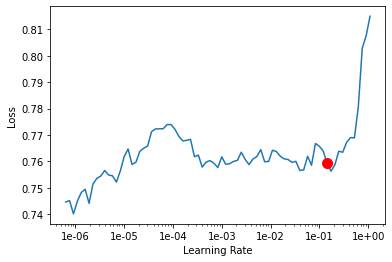

In [20]:
learn_classifier.recorder.plot(suggestion=True)

In [21]:
lr = learn_classifier.recorder.min_grad_lr
lr *= bs/48

In [22]:
# Fit the model based on selected learning rate
learn_classifier.fit_one_cycle(1, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.815715,0.651972,0.674699,07:04


In [23]:
learn_classifier.unfreeze()
learn_classifier.fit_one_cycle(1, lr/10,moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.697457,0.653892,0.674699,07:33


In [24]:
learn_classifier.save(dest/'classifier_fwd')